In [1]:
import pandas as pd
import scipy.io
import numpy as np
import h5py
import pickle
from sklearn.model_selection import train_test_split

X_train = pd.read_pickle('../input/processed-emglab-dataset-for-als-detection/X_train.pkl')
y_train = pd.read_pickle('../input/processed-emglab-dataset-for-als-detection/y_train.pkl')
X_test = pd.read_pickle('../input/processed-emglab-dataset-for-als-detection/X_test.pkl')
y_test = pd.read_pickle('../input/processed-emglab-dataset-for-als-detection/y_test.pkl')

X_train= np.array(X_train)
X_train= X_train.reshape(X_train.shape[0],X_train.shape[1],1)

X_test= np.array(X_test)
X_test= X_test.reshape(X_test.shape[0],X_test.shape[1],1)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 23437, 1)]        0         
_________________________________________________________________
conv1 (Conv1D)               (None, 23427, 32)         384       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 23427, 32)         128       
_________________________________________________________________
conv2 (Conv1D)               (None, 23411, 64)         18496     
_________________________________________________________________
conv2_bn (BatchNormalization (None, 23411, 64)         256       
_________________________________________________________________
conv3 (Conv1D)               (None, 23393, 128)        57472     
_________________________________________________________________
conv3_bn (BatchNormalization (None, 23393, 128)       

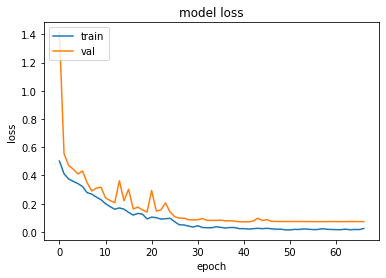

<Figure size 432x288 with 0 Axes>

In [2]:
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, Dense, BatchNormalization, Input, Lambda, Activation, Conv2D, MaxPooling2D, Reshape, Bidirectional, TimeDistributed, GRU, GlobalMaxPooling1D
from keras.layers import concatenate
from keras.models import Model
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger, EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras.models import load_model



def CNN_fibo():
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]),
                        name='input_layer')

    conv1 = Conv1D(filters=32, kernel_size=11, padding='valid', dilation_rate=1, activation='relu',
                   kernel_initializer='he_normal', name='conv1')(input_layer)
    conv1 = BatchNormalization(name='conv1_bn')(conv1)


    conv2 = Conv1D(filters=64, kernel_size=9, padding='valid', dilation_rate=2, activation='relu',
                   kernel_initializer='he_normal', name='conv2')(conv1)
    conv2 = BatchNormalization(name='conv2_bn')(conv2)

    conv3 = Conv1D(filters=128, kernel_size=7, padding='valid', dilation_rate=3, activation='relu',
                   kernel_initializer='he_normal', name='conv3')(conv2)
    conv3 = BatchNormalization(name='conv3_bn')(conv3)


    
    max_pool = GlobalMaxPooling1D(data_format = 'channels_last')(conv3)
#     flatten_block = Flatten()(max_pool)


    emg_block = Dense(64, activation='relu', name='emg_dense1')(max_pool)
    emg_block = BatchNormalization(name='emg_dense1_bn')(emg_block)
    
    emg = Dense(1, activation='sigmoid', name='emg')(emg_block)

    model = Model(inputs=input_layer, outputs=emg)

    return model

model= CNN_fibo()
model.summary()



modelWeightPath = './weight.hdf5'
modelLogPath = './trainingLog.csv'

# model.load_weights(modelWeightPath)

lr = 1e-3
opt = Adam(lr=lr, beta_1=0.9,beta_2=0.999, amsgrad= False, epsilon=None)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[])

# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

 



## %% training callbacks
trainingCallbacks = []
trainingCallbacks.append(ModelCheckpoint(filepath=modelWeightPath, monitor='val_loss', verbose=0, save_best_only=True))
trainingCallbacks.append(EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=25, verbose=0, mode='auto'))
trainingCallbacks.append(ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-10, mode='auto', min_delta=1e-4, cooldown=0))
trainingCallbacks.append(CSVLogger(modelLogPath, separator=',', append=True))

history= model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=100, batch_size=48, callbacks=trainingCallbacks)



print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('./loss.png')

In [3]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='./model_plot.png', show_shapes=False, show_layer_names=True)
model.save('./ALSNet3.hdf5')

In [4]:
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, Dense, BatchNormalization, Input, Lambda, Activation, Conv2D, MaxPooling2D, Reshape, Bidirectional, TimeDistributed, GRU, GlobalMaxPooling1D
from keras.layers import concatenate
from keras.models import Model
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger, EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot


# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=1)
yhat_probs= 1-yhat_probs

# measure best fscore
y_test=1-y_test
precision, recall, thresholds = precision_recall_curve(y_test, yhat_probs)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], fscore[ix], precision[ix], recall[ix]))


# predict classes for threshold
yhat_classes = yhat_probs >= 0.5
cm = confusion_matrix(y_test,yhat_classes)
tn, fp, fn, tp = cm.ravel()

model_precision= tp/(tp+fp)
model_recall= tp/(tp+fn)
model_f= 2*model_precision*model_recall/(model_precision+model_recall)

print('Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (0.5, model_f, model_precision, model_recall))
print('Confusion matrix : \n',cm)

21/21 [==============================] - 1s 41ms/step
Best Threshold=0.622596, F-Score=0.980, Precision=0.978, Recall=0.983
Threshold=0.500000, F-Score=0.979, Precision=0.972, Recall=0.986
Confusion matrix : 
 [[300  10]
 [  5 350]]
